# This is the map pin detection project I created to simply test anomalib. Modify from 000_getting_started.ipynb

## Installing Anomalib

Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:

### I. Install via PyPI

In [1]:
# Option - I: Uncomment the next line if you want to install via pip.
# %pip install anomalib

### II. Install from Source
This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:

In [2]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .

 Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.

In [3]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "145_pin_detect":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/145_pin_detect/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)

## Imports

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType

## Model
I use Fastflow here
- [FastFlow](https://arxiv.org/abs/2111.07677)


## Configuration


In [5]:
MODEL = "fastflow"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: mvtec
  format: mvtec
  path: ./datasets/MVTec
  task: segmentation
  category: mappin
  train_batch_size: 2
  eval_batch_size: 2
  num_workers: 1
  image_size: 256 # dimensions to which images are resized (mandatory) options: [256, 256, 448, 384]
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_

In [6]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)

D:\145\anomalib\src\anomalib\config\config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


## Dataset: Mappin

Got lot of error here 
I use mask as .jpg formate, trans them to .png fix the error.

In [7]:
datamodule = get_datamodule(config)

#datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


Let's check the shapes of the input images and masks.

In [8]:
print(data["image"].shape, data["mask"].shape)

torch.Size([2, 3, 256, 256]) torch.Size([2, 256, 256])


We could now visualize a normal and abnormal sample from the validation set.

D:\145\anomalib\src\anomalib\pre_processing\transforms\custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


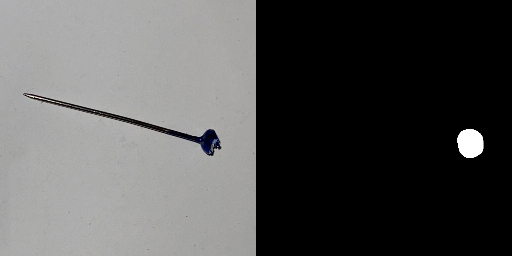

In [9]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Prepare Model and Callbacks


In [10]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"
print(config.optimization.export_mode)
# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

openvino


c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [11]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [12]:
trainer.fit(model=model, datamodule=datamodule)

c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory results\fastflow\mvtec\mappin\run\weights\lightning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | FastflowModel            | 9.7 M 
3 | loss                  | FastflowLoss             | 0     
4 | image_metrics         | A

c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a b

Training: 0it [00:00, ?it/s]

c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\onnx\_internal\jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ..\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\onnx\utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ..\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\onnx\utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op

## Validation

In [13]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


c:\Users\god14\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.992559552192688     │
│       image_F1Score       │    0.9600000381469727     │
│        pixel_AUROC        │     0.947176456451416     │
│       pixel_F1Score       │    0.2864791750907898     │
└───────────────────────────┴───────────────────────────┘

## OpenVINO Inference

### Load a Test Image


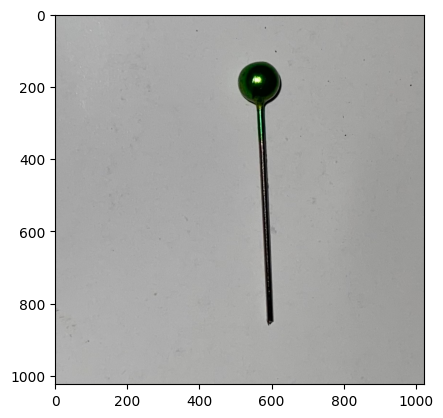

In [14]:
image_path = root_directory / "datasets/MVTec/mappin/test/short/01.png"
image_test = read_image(path="./datasets/MVTec/mappin/test/short/01.png")
plt.imshow(image_test)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.

In [15]:
output_path = Path(config["project"]["path"])
print(output_path)

results\fastflow\mvtec\mappin\run


In [16]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata.exists())

True True


In [17]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference
Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.

ov.get_version
2023.2.0-13089-cfd42bd2cb0-HEAD
error here
RuntimeError: Exception from src\inference\src\infer_request.cpp:231:
label is too far

uninstall 2023.2.0 and install 2023.0.0 make it work

In [18]:
print(image_test.shape)
import openvino.runtime as ov
print(ov.get_version())


(1024, 1024, 3)
2023.2.0-12538-e7c1344d3c3


In [19]:
predictions = inferencer.predict(image=image_test)

RuntimeError: Exception from src\inference\src\infer_request.cpp:229:
label is too far


where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.

### Visualizing Inference Results

In [ ]:
print(predictions.pred_score, predictions.pred_label)

In [ ]:
# Visualize the original image
plt.imshow(predictions.image)

In [ ]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

In [ ]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

In [ ]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

In [ ]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)

This wraps the `getting_started` notebook. There are a lot more functionalities that could be explored in the library. Please refer to the [documentation](https://openvinotoolkit.github.io/anomalib/) for more details.